In [2]:
# SPI model fitting with Stan
# Example: fitting two BG models + one nova model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan_utility
import pystan
import pickle
import sys
import time
from IPython.display import Image

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from angular_distance import angular_distance
plt.style.use('thomas')

<h3>Reading in the data set</h3>

<h3>Data set (counts) in evts_det_spec.fits file:</h3>

In [3]:
with fits.open('evts_det_spec_filter.fits.gz') as content:
    evts = content[1].data

<h3>Energy boundaries definition (not important in our case, just illustration purpose):</h3>

In [4]:
with fits.open('energy_boundaries.fits.gz') as content:
    ebds = content[1].data

<h3>Pointing definition in pointin.fits file:</h3>

In [5]:
with fits.open('pointing_filter.fits.gz') as content:
    poin = content[1].data

<h3>Detector dead time in dead_time.fits file:</h3>

In [6]:
with fits.open('dead_time_filter.fits.gz') as content:
    dead = content[1].data

<h3>Background model (already scaled to data) in back_model.fits file:</h3>

In [7]:
with fits.open('back_model.fits.gz') as content:
    bgc = content[2].data
    bgl = content[3].data

<h3>Already-convolved sky model response of nova V595 Mon (index 50)</h3>

In [8]:
with fits.open('convskys/convsky_model_SPI_22Na_nova050_pointsource_V959_Mon.fits') as content:
    nova = content[2].data

<h3>Complete INTEGRAL nova catalogue until 2018 (see earlier notebooks):</h3>

In [9]:
data_frame = pd.read_csv('INTEGRAL_novae_wTimes.csv')
good_novae = np.where(~np.isnan(data_frame['IJD']) &
                      (data_frame['Dist. \n(kpc)']+data_frame['Dist. Err. (kpc)'] < 25) &
                      ((data_frame['Var. type'] == 'N') |
                       (data_frame['Var. type'] == 'NAa') | 
                       (data_frame['Var. type'] == 'NB') |
                       (data_frame['Var. type'] == 'NC') |
                       (data_frame['Var. type'] == 'NTS')))[0]

<h3>What's in the files (reminder: we already did something with the pointings file earlier):</h3>

In [10]:
poin.columns

ColDefs(
    name = 'PTID_ISOC'; format = '8A'
    name = 'PTID_SPI'; format = '15A'
    name = 'OBT_START'; format = '4I'; bzero = 32768
    name = 'OBT_END'; format = '4I'; bzero = 32768
    name = 'TSTART'; format = 'D'
    name = 'TSTOP'; format = 'D'
    name = 'TELAPSE'; format = 'D'
    name = 'RA_SPIX'; format = 'E'
    name = 'DEC_SPIX'; format = 'E'
    name = 'RA_SPIZ'; format = 'E'
    name = 'DEC_SPIZ'; format = 'E'
)

<h3>PTID_ISOC: identifier<br>
    PTID_SPI:  identifier<br>
    OBT_START/END: onboard clock start and end times of pointing definition<br>
    TSTART/STOP: start and end time of pointing in IJD<br>
    TELAPSE: length of pointing (in s)<br>
    RA/DEC_SPIX: pointing/spacecraft direction (optical axis / zenith) in right-ascesion / declination deg<br>
    RA/DEC_SPIZ: pointing/spacecraft direction (facing the Sun)</h3>

In [11]:
Np = len(poin)
p = np.arange(Np)
Np

99880

<h3>Recap: Plotting the pointing positions in the sky:<br>
    1) Read corresponding columns in poin object<br>
    2) Convert to galactic coordinates<br>
    3) Plot</h3>

In [12]:
# 1)
ra_spi  = poin['RA_SPIX']
dec_spi = poin['DEC_SPIX']

# 2)
poin_coords = SkyCoord(ra=ra_spi,
                       dec=dec_spi,
                       unit='deg')
# this creates an object which holds RA and DEC values in units of degrees

lon_spi = poin_coords.galactic.l.value
lon_spi[lon_spi>180]-=360 # shifting the coordiantes to -180 to +180 deg
lat_spi = poin_coords.galactic.b.value

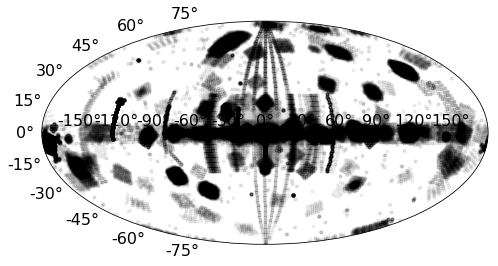

In [13]:
# 3)
plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(lon_spi), # aitoff  projection needs rad, not deg
            np.deg2rad(lat_spi),
            marker='.',alpha=0.05)

In [14]:
poin['TELAPSE'].min(),poin['TELAPSE'].max()

(116.46401048346888, 42783.999999998196)

<h3>Where is our nova?<br>
    1) Read from nova catalogue<br>
    2) Store in array<br>
    3) Call to right index</h3>

In [15]:
Nn = len(good_novae)
Nn

102

In [16]:
# 2)
c_arr = []
# 1)
for i in range(Nn):
    c = SkyCoord(ra=data_frame['Ra\n(deg)'][good_novae[i]],
                 dec=data_frame['Dec\n(deg)'][good_novae[i]],
                 unit=(u.degree, u.degree))
    c_arr.append([c.galactic.l.deg,
                  c.galactic.b.deg,
                  data_frame['l\n(deg)'][good_novae[i]],
                  data_frame['b\n(deg)'][good_novae[i]]])
# 2)
c_arr = np.array(c_arr)
c_arr[np.where(c_arr > 180)] -= 360

# 3)
ndx = 50

In [17]:
print('Coordinates of '+data_frame['Name'][good_novae[ndx]]+': (l/b) = (%.2f/%.2f)' % (c_arr[ndx,0],c_arr[ndx,1]))

Coordinates of V959 Mon: (l/b) = (-153.66/0.08)


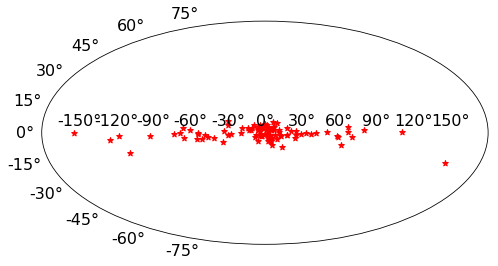

In [18]:
# all INTEGRAL novae
plt.subplot(projection='aitoff')
plt.scatter(np.deg2rad(c_arr[:,0]), # aitoff  projection needs rad, not deg
            np.deg2rad(c_arr[:,1]),
            marker='*',alpha=1,color='red')

<h3>What's in the convolved sky model?</h3>

In [19]:
nova.columns

ColDefs(
    name = 'COUNTS'; format = '1E'
    name = 'STAT_ERR'; format = '1E'
)

<h3>COUNTS: expected counts per detector per pointing, normalised to a flux of $2 \times 10^{-3}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$ @ $1275\,\mathrm{keV}$ in a $20\,\mathrm{keV}$ broad energy bin<br>
    STAT_ERR: no information</h3>

In [20]:
nova['COUNTS'].shape

(1897720,)

<h3>The expectations are in an unravelled format: pointing x detector. We reshape this for later input in our Stan model:</h3>

In [21]:
Nrsp = 19 # 19 detectors

In [22]:
nova_model = nova['COUNTS'].reshape(Np,Nrsp)

In [23]:
nova_model.shape

(99880, 19)

<h3>Angular distance of pur nova to each pointing:</h3>

In [24]:
angdist = angular_distance(c_arr[ndx,0],c_arr[ndx,1],lon_spi,lat_spi)

<h3>How do the angular distance and our nova model work out?</h3>

(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text yticklabel objects>)

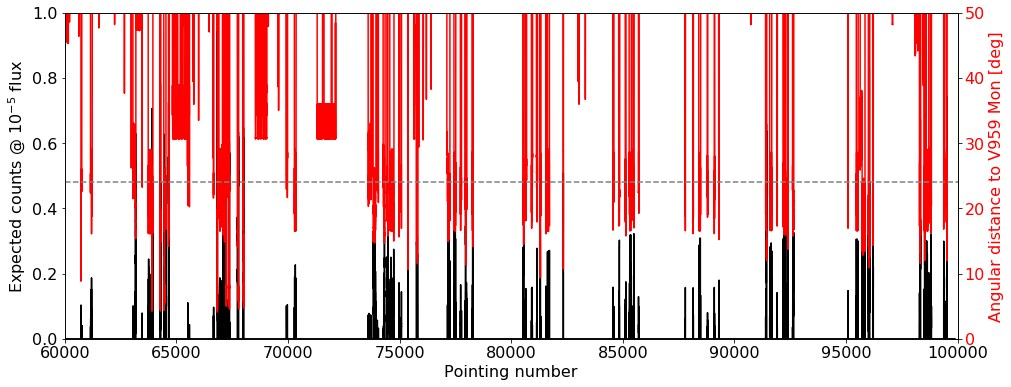

In [25]:
plt.figure(figsize=(16,6))
plt.step(p,np.nansum(nova_model,axis=1)/2e2,'-',where='mid')
plt.ylim(0,1)
plt.ylabel(r'Expected counts @ $10^{-5}$ flux')
plt.xlabel('Pointing number')

plt.twinx()
plt.step(p,angdist,color='red',where='mid')
plt.axhline(24,linestyle='--',color='gray')
plt.xlim(60000,100000)
plt.ylim(0,50)
plt.ylabel('Angular distance to '+data_frame['Name'][good_novae[ndx]]+' [deg]',color='red')
plt.yticks(color='red')

(0, 30)

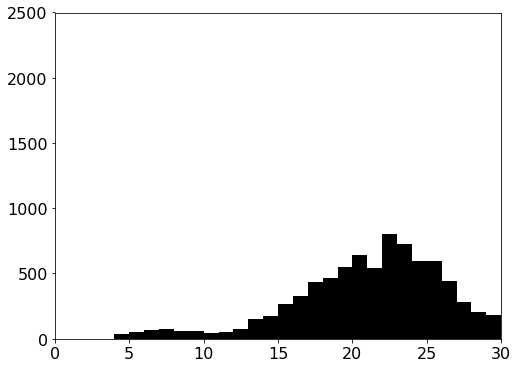

In [26]:
plt.hist(angdist,bins=np.arange(0,180));
plt.xlim(0,30)

<h3>Only when the angular distance of a pointing to the source is below ~24 deg, we expect the instrument to detect any counts. This is the maximum angular distance used in the calculation of the response, and defined by the imaging response file.</h3>

<h3>How does the data now look like, compared to the background and this sky model?<br>
    We define a slightly adapted version of the SPIl_plot function from the last notebook.</h3>

In [27]:
def SPIl_plot(p,
              y,color='black',label=None,
              y2=None,color2='red',label2=None,
              y3=None,color3='blue',label3=None,
              y4=None,color4='lime',label4=None):
    pp = np.sort(np.concatenate([p + i/19*0.5 for i in range(-19,19,2)])) # array for plotting
    plt.figure(figsize=(16,6))
    plt.step(pp,y.ravel(),color=color,label=label,where='mid')
    if np.any(y2 != None):
        plt.step(pp,y2.ravel(),color=color2,label=label2,where='mid')
    if np.any(y3 != None):
        plt.step(pp,y3.ravel(),color=color3,label=label3,where='mid')
    if np.any(y4 != None):
        plt.step(pp,y4.ravel(),color=color4,label=label4,where='mid')
    if len(p) < 50:
        for i in range(len(p)+1):
            plt.axvline(i-0.5,linestyle='--',color='black',alpha=0.1)
    plt.xlabel('Pointing number')
    plt.xlim(p[0]-0.5,p[-1]+0.5)
    plt.ylabel('Counts')
    plt.legend()

<h3>And also reshape the data and the background</h3>

In [28]:
all_data = evts['COUNTS'].reshape(Np,Nrsp,5)

In [29]:
emin = ebds['E_MIN']
emax = ebds['E_MAX']
ewid = 0.5*(emax-emin)
ecen = 0.5*(emax+emin)
ecen[2],ewid[2]*2

(1275.0, 20.0)

In [30]:
data = evts['COUNTS'][:,2].reshape(Np,Nrsp) # the "2" comes formr the central bin
bgc_model = bgc['COUNTS'][:,2].reshape(Np,Nrsp)
bgl_model = bgl['COUNTS'][:,2].reshape(Np,Nrsp)

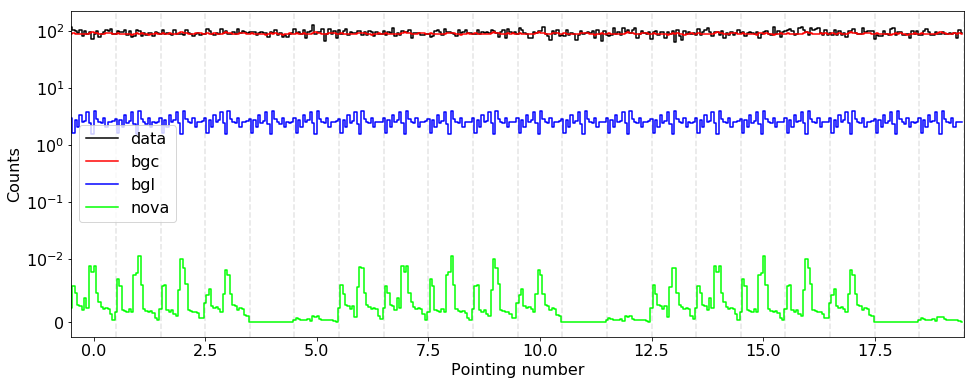

In [31]:
Np_tmp = 20
SPIl_plot(p[0:Np_tmp],data[0:Np_tmp,:],label='data',
          y2=bgc_model[0:Np_tmp,:],label2='bgc',
          y3=bgl_model[0:Np_tmp,:],label3='bgl',
          y4=nova_model[0:Np_tmp,:]/2e2,label4='nova')
plt.yscale('symlog',linthreshy=1e-2)

<h3>Maximum expected SNR for this nova with exponential decay and a flux of $10^{-5}$:</h3>

In [32]:
days = poin['TSTART']# - poin['TSTART'].min()

In [33]:
# explosion date
T0 = data_frame['IJD'][good_novae].values[ndx]
T0

4604.804803240739

In [34]:
# decay constant
tau = 2.602/np.log(2)*365.25
tau

1371.1092343075734

In [35]:
# summing over all detectors (axis=1)
nova_counts_time = np.nansum(nova_model/2e2,axis=1) # /2e2 to make 2e-3 to 1e-5

In [36]:
nova_counts_time.shape

(99880,)

In [37]:
# applying exponential decay function
nova_counts_decay = nova_counts_time*np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau)

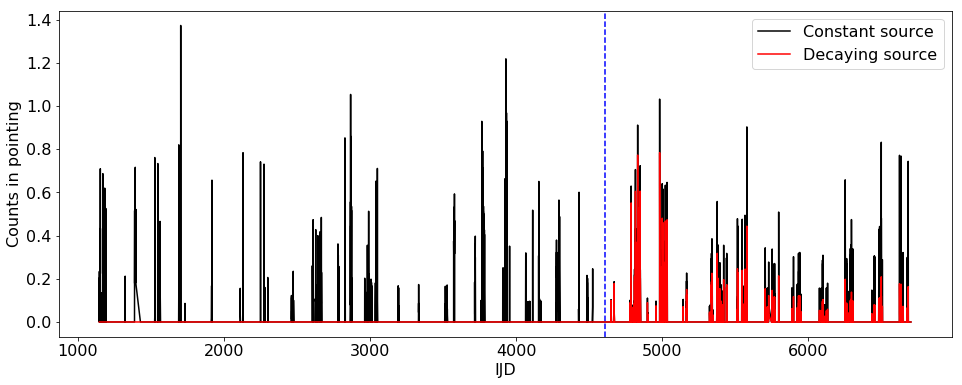

In [38]:
plt.figure(figsize=(16,6))
plt.plot(days,nova_counts_time,label='Constant source')
plt.plot(days,nova_counts_decay,label='Decaying source')
plt.axvline(T0,linestyle='--',color='blue')
plt.xlabel('IJD')
plt.ylabel('Counts in pointing')
plt.legend()
#plt.xlim(T0,)

In [39]:
# same for the data to get total counts in each pointing
data_counts_time = np.sum(data,axis=1)

In [40]:
# remember SNR from last notebook
snr_nova_decay = np.sqrt(np.nancumsum((nova_counts_decay / np.sqrt(data_counts_time))**2))

snr_nova_const = np.sqrt(np.nancumsum((nova_counts_time / np.sqrt(data_counts_time))**2))

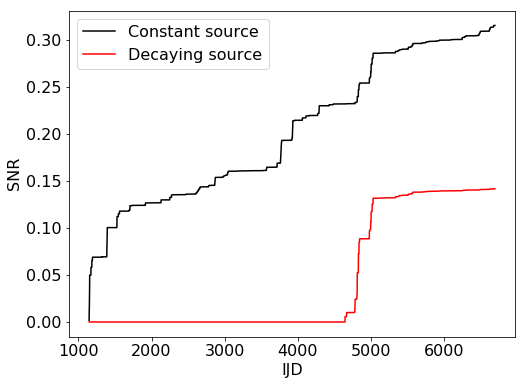

In [41]:
plt.plot(days,snr_nova_const,label='Constant source')
plt.plot(days,snr_nova_decay,label='Decaying source')
plt.xlabel('IJD')
plt.ylabel('SNR')
plt.legend()

In [42]:
snr_nova_const.max(),snr_nova_decay.max()

(0.3156456064226882, 0.1417811717034383)

In [43]:
1e-5/snr_nova_const.max(),1e-5/snr_nova_decay.max()

(3.168109993144899e-05, 7.053122695950674e-05)

<h3>As we see, we would expect to see nothing in this case (neither decay nor constant).<br>
    We can estimate roughly what errorbars we would expect for the flux in the following manner (this is called sensitivity of the instrument):<br>
    The maximum SNR is the last point in the plot, and defines the "fractional size" of the flux errorbar in units of the chosen example, herer $10^{-5}$. Thus, the $0.31$ (const) and $0.14$ (decay) flux errorbar would be $10^{-5}$. Likewise, a $1\sigma$-errorbar would be $10^{-5}/0.31 = 3.2 \times 10^{-5}$ and $10^{-5}/0.14 = 6.9 \times 10^{-5}$, respectively.<br>While this is not completely correct (because all these estimates assume things to be normal distributed, and use fractional counts(!)), it may well serve as order of magnitude estimate. Within factors of $\sim 10$, we can expect the uncertainty on the flux, which we are interested in.</h3>

<h3>Having a look at the data and different model components now as a function of time. Here we use the counts per time to be able to compare them directly (absolute counts can be misleading):</h3>

<h5>Introducing the livetime per detector:</h5>

In [44]:
livetime = dead['livetime'].reshape(Np,Nrsp)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


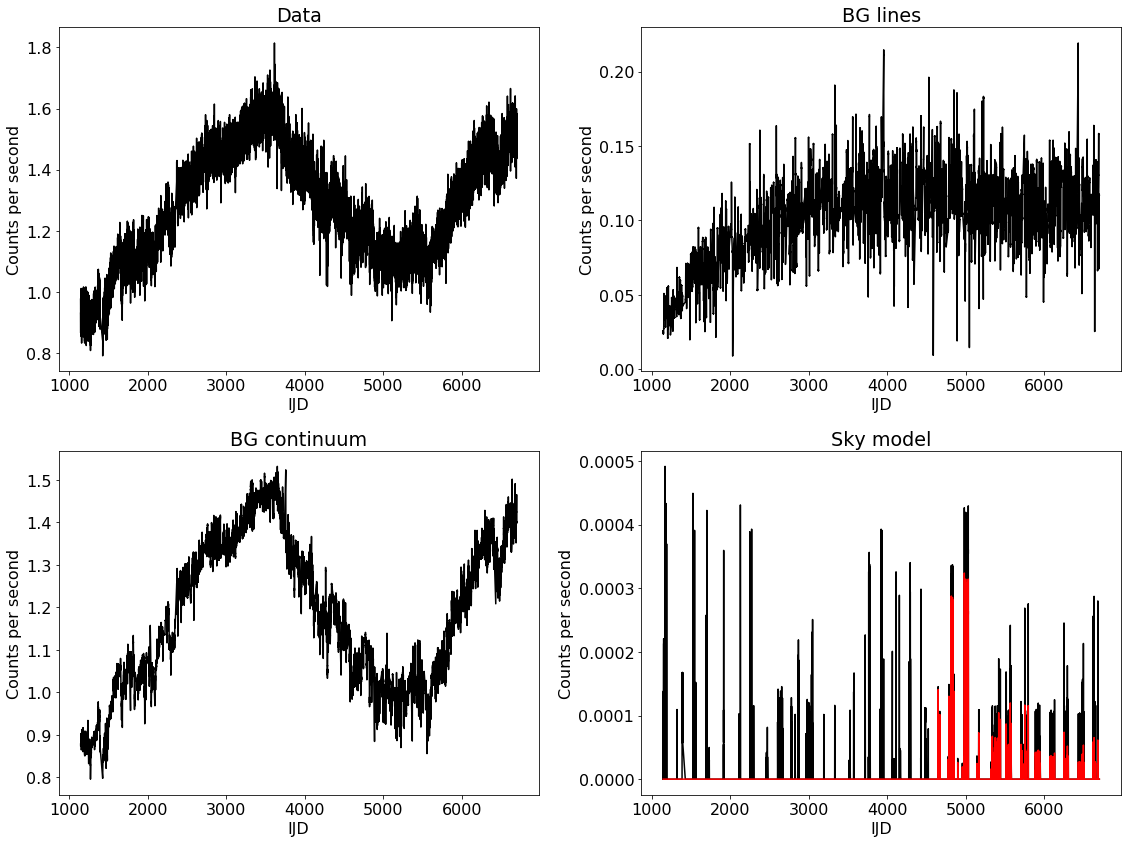

In [45]:
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.plot(days,np.nansum(data/livetime,axis=1))
plt.ylabel('Counts per second')
plt.xlabel('IJD')
plt.title('Data')

plt.subplot(222)
plt.plot(days,np.nansum(np.abs(bgl_model)/livetime,axis=1))
plt.ylabel('Counts per second')
plt.xlabel('IJD')
plt.title('BG lines')

plt.subplot(223)
plt.plot(days,np.nansum(bgc_model/livetime,axis=1))
plt.ylabel('Counts per second')
plt.xlabel('IJD')
plt.title('BG continuum')

plt.subplot(224)
plt.plot(days,np.nansum(nova_model/livetime/2e2,axis=1))
plt.plot(days,np.nansum(nova_model/livetime/2e2,axis=1)*np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau))
plt.ylabel('Counts per second')
plt.xlabel('IJD')
plt.title('Sky model')

plt.tight_layout()

<h3>And in detector space:</h3>

In [46]:
d = np.arange(Nrsp)

<h5>Definition of epochs (when 19 detectors worked, 18, 17, ...)</h5>

In [47]:
#ep = np.array([1, 4957, 9121, 37240, 45823])-1

# all INTEGRAL revolutions
revol_arr = np.array([float(poin['PTID_SPI'][i])/1e4 for i in range(Np)])

# detector failure times
ep1 = np.where(revol_arr < 140)[0]
ep2 = np.where((revol_arr >= 140) & (revol_arr < 214))[0]
ep3 = np.where((revol_arr >= 214) & (revol_arr < 775))[0]
ep4 = np.where((revol_arr >= 775) & (revol_arr < 930))[0]
ep5 = np.where(revol_arr >= 930)[0]

ep = np.array([ep1[0],ep2[0],ep3[0],ep4[0],ep5[0]])
ep

array([    0,  4956,  9120, 37239, 45822])

In [48]:
# mean over ep1:
det_ratio_bgc_ep1 = np.mean((bgc_model[ep1,:]/np.nanmean(bgc_model[ep1,:])),axis=0)

(-0.5, 18.5)

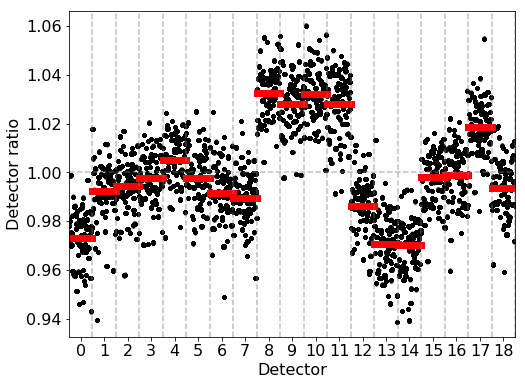

In [49]:
for i in range(len(ep1)):
    plt.plot(d-0.5+i/len(ep1),bgc_model[ep1[i],:]/np.nanmean(bgc_model[ep1[i],:]),'k.')
for j in range(Nrsp):
    plt.plot([j-0.5,j+0.5],np.repeat(det_ratio_bgc_ep1[j],2),color='red',linewidth=7)
    plt.axvline(j+0.5,linestyle='--',alpha=0.5,color='gray')
plt.xticks(ticks=np.arange(0,19))
plt.xlabel('Detector')
plt.ylabel('Detector ratio')
plt.axhline(1,linestyle='--',color='gray',alpha=0.5)
plt.xlim(-0.5,18.5)

<h3>There is probably a faster way to plot this, but okay.</h3>

<h3>And what you already thought:</h3>

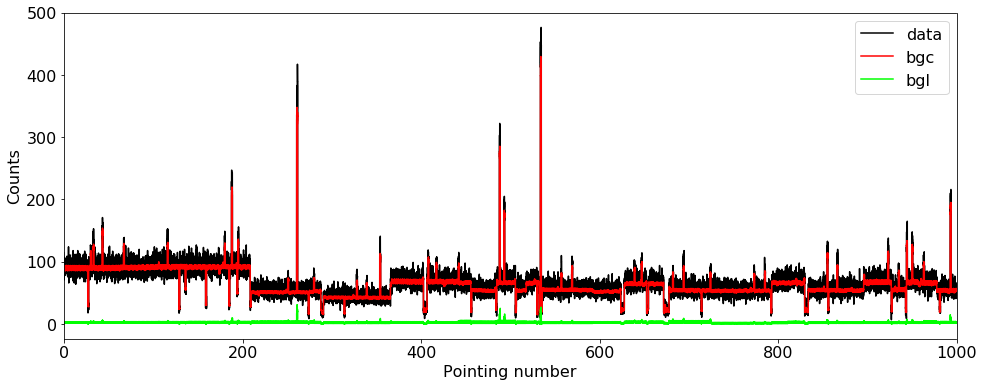

In [50]:
SPIl_plot(p[0:1000],data[0:1000,:],label='data',color='black',
          y2=bgc_model[0:1000,:],label2='bgc',color2='red',
          y3=bgl_model[0:1000,:],label3='bgl',color3='lime')

<h3>And our distribution of residuals without we fit anything:</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Frequency')

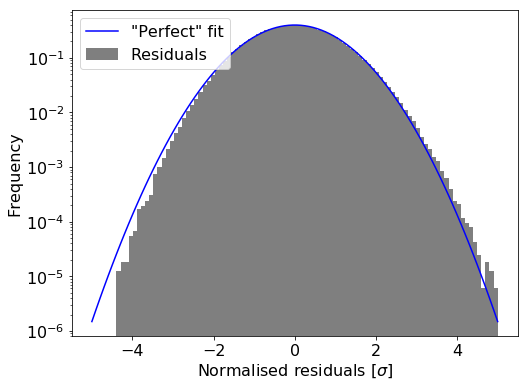

In [51]:
# (data - model)/sqrt(model) --- should be familiar by now

plt.hist(((data[0:Np,:]-(bgl_model[0:Np,:]+bgc_model[0:Np,:]))/(np.sqrt(bgl_model[0:Np,:]+bgc_model[0:Np,:]))).ravel(),
         bins=np.linspace(-5,5,100),alpha=0.5,density=True,label='Residuals');

x2 = np.linspace(-5,5,100)
plt.plot(x2,1/np.sqrt(2*np.pi)*np.exp(-0.5*x2**2),color='blue',label='"Perfect" fit')

plt.legend()
         
plt.yscale('log')

plt.xlabel(r'Normalised residuals [$\sigma$]')
plt.ylabel('Frequency')

<h3>We see the distribution is slightly shifted / has an excess at positive values. This is good as it indicates that there is "signal" included which we didn't account for, yet.</h3>

<h3>Okay, now we fit. We need a slightly adapted version of the spimodfit.stan model which we used earlier, because we have to deal to failed detectors, and fitting zeros to zeros is a waste of time (and not possible):</h3>

<h3>We define test cases as the complete run takes a while (see below):</h3>

In [52]:
Np_tmp = 1000 # we use 1000 pointings to start with

In [53]:
tmp_data = data.reshape(Np,Nrsp)[0:Np_tmp,:]
tmp_bgl  = bgl_model[0:Np_tmp,:]
tmp_bgc  = bgc_model[0:Np_tmp,:]
tmp_sky  = nova_model[0:Np_tmp,:].reshape(1,Np_tmp,Nrsp)

<h3>We take care of the zeros by finding the indices where data and background (and possibly sky) are <em>always</em> zero so that we can ignore them in the fit:</h3>

In [54]:
idx = np.where(~((tmp_data.ravel() == 0) & (tmp_bgl.ravel() == 0) & (tmp_bgc.ravel() == 0)))[0] + 1
Ngood = len(idx)

In [55]:
idx,Ngood

(array([    1,     2,     3, ..., 18998, 18999, 19000]), 19000)

<h5>In this case, all pointings are included (as expected)</h5>

<h5>For our background model to work, we have to identify and transfer change points (if any). This is done by the following function (details later).</h5>

In [56]:
# same as in other notebook

def make_bg_cuts(cuts,Np):
    cuts = [1] + cuts + [1e99]
    bg_cuts = np.zeros(Np)
    cidx = 0
    for i in range(1,Np+1):
        #print(i)
        if (cuts[cidx] <= i < cuts[cidx+1]):
            bg_cuts[i-1] = cuts[cidx]
        else:
            cidx += 1
            bg_cuts[i-1] = cuts[cidx]
            
    Ncuts = len(np.unique(bg_cuts))
    idx_arr = np.ones(Np)
    for i in range(Ncuts):
        idx_arr[np.where(bg_cuts == cuts[i+1])[0]] = i+1
    
    return bg_cuts.astype(int), idx_arr.astype(int), Ncuts

<h3>Our new stan model</h3>

In [57]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('spimodfit_bg_conti_sep_nozeros.pkl', 'rb'))

except:
    print('Stan model not yet compiled, doing that now')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('spimodfit_bg_conti_sep_nozeros.stan')

    ## save it to the file 'filename.pkl' for later use
    with open('spimodfit_bg_conti_sep_nozeros.pkl', 'wb') as f:
        pickle.dump(model, f)

<h3>Setting up the data for the fit is also the same, just there are more entries in the data dictionary</h3>

In [58]:
mu_flux_scl = np.array([1.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([1.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg_lines = 1.                      # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg_lines = 0.1                  # same
mu_Abg_conti = 1.                      # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg_conti = 0.1                  # same

# background cuts (here only one parameter for all times)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(1,Np,100)),Np)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np_tmp)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_tmp,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = tmp_data.ravel().astype(int),
              bg_model_lines = np.abs(tmp_bgl),
              bg_model_conti = np.abs(tmp_bgc),
              conv_sky = tmp_sky, # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

<h5>Now, let's only optimise the posterior and plot the result:</h5>

In [59]:
init = {}
init['flux'] = np.array([1.0])
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)
start = time.time()
op = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)
op

0.34185099601745605


OrderedDict([('par',
              OrderedDict([('flux', array(7.69653861e-05)),
                           ('Abg_lines', array(1.00453006)),
                           ('Abg_conti', array(1.00104757)),
                           ('model_values',
                            array([90.54558732, 92.82276659, 91.33303848, ..., 57.32879245,
                                   59.45170294, 56.17208272])),
                           ('model_values_g',
                            array([90.54558732, 92.82276659, 91.33303848, ..., 57.32879245,
                                   59.45170294, 56.17208272])),
                           ('ppc',
                            array([101.,  96.,  72., ...,  54.,  43.,  69.])),
                           ('model_tot',
                            array([1752.15332526, 1724.13319397, 1754.94654425, 1757.38120321,
                                   1725.32359604, 1756.28588225, 1730.30410148, 1753.76407938,
                                   1731.62649107, 

<h5>The flux value here is not necessarily useful as we didn't sample the full posterior yet, but at least we see that the fit works.</h5>

In [60]:
fitted_model = op['par']['model_tot']

In [61]:
fitted_model_all = op['par']['model_values'].reshape((Np_tmp,Nrsp))

In [62]:
fitted_bgl = op['par']['model_bg_lines']

In [63]:
fitted_bgc = op['par']['model_bg_conti']

In [64]:
fitted_sky = op['par']['model_sky'][0,:]

Text(0, 0.5, 'Counts')

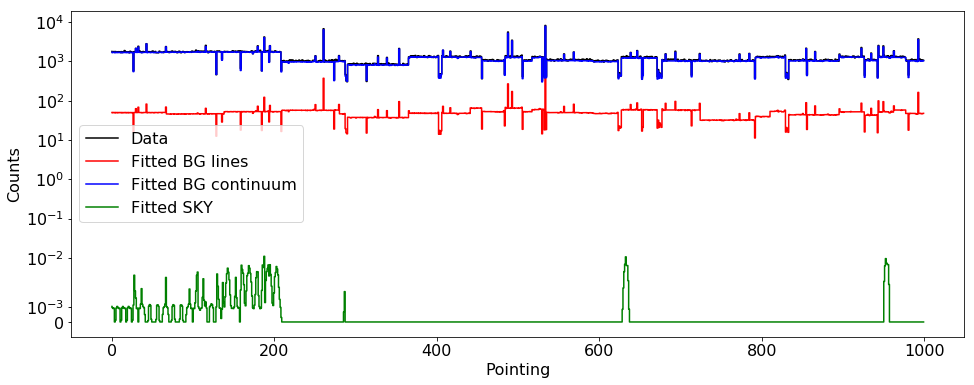

In [65]:
plt.figure(figsize=(16,6))

plt.step(np.arange(0,Np_tmp),np.sum(tmp_data[0:Np,:],axis=1),label='Data')
#plt.step(np.arange(0,Np_tmp),fitted_model)
plt.step(np.arange(0,Np_tmp),fitted_bgl,label='Fitted BG lines')
plt.step(np.arange(0,Np_tmp),fitted_bgc,label='Fitted BG continuum')
plt.step(np.arange(0,Np_tmp),fitted_sky,label='Fitted SKY')
plt.legend()
plt.yscale('symlog',linthreshy=3e-3)
plt.xlabel('Pointing')
plt.ylabel('Counts')

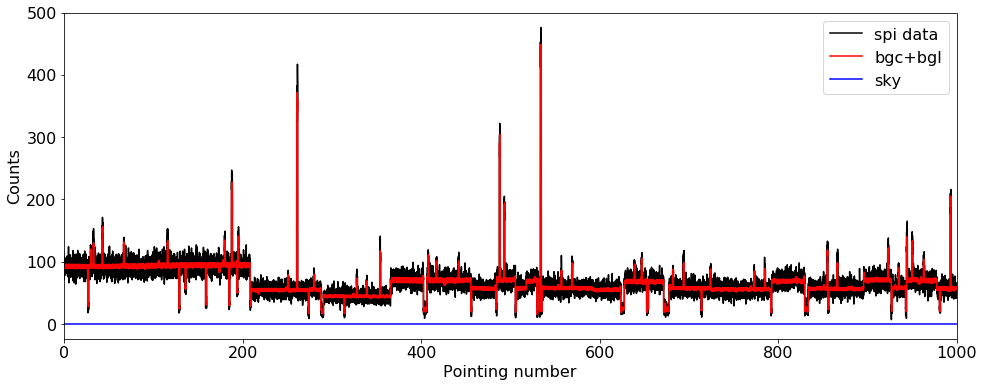

In [66]:
SPIl_plot(np.arange(0,Np_tmp),
          tmp_data,color='black',label='spi data',
          y2=fitted_model_all,color2='red',label2='bgc+bgl',
          y3=nova_model[0:Np_tmp,:]*op['par']['flux'],color3='blue',label3='sky')

<h3>Now sampling</h3>

In [67]:
start = time.time()
op2 = model.sampling(data=data2D,chains=1,iter=1000,n_jobs=-1,verbose=True,pars=['flux','Abg_lines','Abg_conti'])
print(time.time()-start)

94.4928822517395


<h3>Even in this case, the fit took almost two minutes for me. I ran a complete thing with 1000 fit parameters per background model and all 99880 pointings, which took about one day (~8 hours in sleep mode), so around 16 hours. This is not yet optimised, i.e. how many parameters we need, etc.<br><br>
    You might want to check how long a complete fit (in the example below the result) takes for your computer (if it doesn't crash).</h3>

In [68]:
print(op2.stansummary(['flux','Abg_lines','Abg_conti']))

Inference for Stan model: anon_model_82974d80982aabf2b11051a2be36db84.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]        0.04  2.2e-3   0.03 2.3e-3   0.01   0.03   0.05   0.11    179    1.0
Abg_lines[1]   1.01  3.5e-3   0.05   0.91   0.98   1.01   1.04    1.1    190    1.0
Abg_conti[1]    1.0  1.4e-4 2.1e-3    1.0    1.0    1.0    1.0   1.01    235    1.0

Samples were drawn using NUTS at Thu Jul 30 16:08:03 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h5>What do our posterior distributions for flux and Abg look like?</h5>

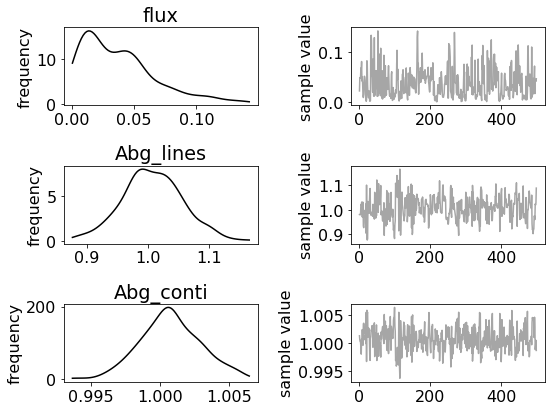

In [69]:
op2.plot(['flux','Abg_lines','Abg_conti']);
plt.tight_layout()

<h3>We see that our flux is pretty much consistent with zero, as expected, and we calculate the $3\sigma$ limit on the flux by using the 99.85th percentile:</h3>

In [70]:
print('Upper limit (3sigma) on the 22Na (1275 keV) flux of '+data_frame['Name'][good_novae[ndx]]+': %.0fe-5' % (np.percentile(op2['flux'],99.85)*2e-3*1e5))

Upper limit (3sigma) on the 22Na (1275 keV) flux of V959 Mon: 28e-5


<h3>Estimate of the sensitivity</h3>

In [71]:
np.count_nonzero(np.sum(tmp_sky,axis=(0,2))),len(np.sum(tmp_sky,axis=(0,2)))

(193, 1000)

In [72]:
np.count_nonzero(np.sum(nova_model[0:Np,:],axis=(1))),len(np.sum(nova_model[0:Np,:],axis=(1)))

(5653, 99880)

In [73]:
5653/193

29.29015544041451

In [74]:
np.sqrt(5653/193)

5.412038011730378

In [75]:
(np.percentile(op2['flux'],99.85)*2e-3)/np.sqrt(5653/193)

5.258667347076319e-05

<h3>Using useful cuts for the background:</h3>

<h3>Typically, background changes on the time scale of one orbit. Thus, we want to find the indices where a new INTEGRAL revolution starts:</h3>

In [76]:
revolutions, rev_idx = np.unique(np.floor(revol_arr),return_index=True)

In [77]:
rev_idx += 1 #+1 for stan

<h3>Total number of revolutions (partially) in data set:</h3>

In [78]:
len(rev_idx)

1674

<h3>That's a lot, but in fact speeds up things because the fit finds its optimum faster. Needs to be multiplied by two because we have two background models. We can try "every 2 revolutions", "every 4 revolutions", etc to find optimum. Still 1 revolution works usually best.<br>
    But: Always need to consider the failed detectors:</h3>

<h3>Failed detector times from: http://www.isdc.unige.ch/integral/download/osa/doc/10.1/osa_um_spi/node69.html</h3>

In [79]:
det_failures_IJD = np.array([1435.41635,1659.46000,3337.50000,3799.66740])

<h3>We search for the nearest pointing <em>after</em> which these times are met:</h3>

In [80]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [81]:
df_idx = np.array([find_nearest(poin['TSTART'],i) for i in det_failures_IJD])

In [82]:
df_idx

array([ 4956,  9166, 37284, 45822])

In [84]:
poin['TSTART'][df_idx]

array([1435.6234975 , 1658.97936556, 3336.80731694, 3801.48956382])

<h3>Check if it is really <em>after<em> the detector failure</h3>

In [85]:
df_idx[np.where(poin['TSTART'][df_idx] < det_failures_IJD)[0]] += 1

In [86]:
df_idx

array([ 4956,  9167, 37285, 45822])

In [87]:
poin['TSTART'][df_idx]

array([1435.6234975 , 1659.95031463, 3338.43404148, 3801.48956382])

In [88]:
df_idx += 1 #+1 for stan

In [89]:
df_idx

array([ 4957,  9168, 37286, 45823])

<h3>We also need to use the time between two annealings of the SPI camera, as there, the background rate changes a lot. This is typically per half a year, but varies in detail. The (approximate) times are:</h3>

In [90]:
annealing_revs = np.array([40,94,134,207,279,328,397,449,508,568,644,717,
                           799,860,913,978,1044,1115,1180,1251,1321,1374,
                           1452,1509,1587,1654,1707,1773,1845,1915])

In [91]:
annealing_revs

array([  40,   94,  134,  207,  279,  328,  397,  449,  508,  568,  644,
        717,  799,  860,  913,  978, 1044, 1115, 1180, 1251, 1321, 1374,
       1452, 1509, 1587, 1654, 1707, 1773, 1845, 1915])

<h3>Find nearest revolution <em>after</em> an annealing:</h3>

In [92]:
ann_idx_tmp = np.array([find_nearest(revolutions,i) for i in annealing_revs])

In [93]:
ann_idx_tmp

array([   0,   45,   76,  142,  201,  244,  295,  338,  391,  444,  513,
        579,  654,  709,  756,  814,  874,  936,  988, 1050, 1113, 1160,
       1231, 1283, 1350, 1410, 1457, 1517, 1583, 1642])

<h3>Make sure it's really <em>after</em></h3>

In [94]:
ann_idx_tmp[np.where(revolutions[ann_idx_tmp] < annealing_revs)[0]] += 1

In [95]:
ann_idx_tmp += 1 #Stan

In [96]:
ann_idx_tmp = np.delete(ann_idx_tmp,0) # get rid of the first entry as already included in the revolution indices

In [97]:
ann_idx_tmp

array([  47,   77,  144,  203,  245,  297,  339,  393,  445,  515,  580,
        656,  710,  758,  816,  876,  937,  990, 1052, 1115, 1162, 1233,
       1285, 1352, 1412, 1459, 1519, 1585, 1644])

<h3>The revolutions after an annealing are thus:</h3>

In [98]:
revolutions[ann_idx_tmp-1]

array([  97.,  137.,  210.,  283.,  331.,  402.,  452.,  512.,  571.,
        648.,  720.,  803.,  863.,  916.,  982., 1048., 1118., 1184.,
       1255., 1325., 1378., 1455., 1513., 1591., 1657., 1711., 1777.,
       1849., 1920.])

<h3>Finally, find the appropriate pointing indices:</h3>

In [99]:
ann_idx = np.array([rev_idx[np.where(revolutions == revolutions[ann_idx_tmp[i]-1])[0][0]] for i in range(len(ann_idx_tmp))])

In [100]:
#ann_idx += 1 #stan @ already included in rev_idx

In [101]:
ann_idx

array([ 2944,  4728,  8925, 12576, 15282, 18039, 20403, 23277, 26140,
       30279, 33944, 38540, 41881, 44874, 48400, 52156, 55584, 59029,
       62830, 66783, 69883, 74205, 77313, 81165, 85108, 87530, 91139,
       95074, 98235])

In [102]:
poin['TSTART'][ann_idx-1]

array([1306.96514102, 1426.61951602, 1645.00247898, 1863.35992111,
       2006.92113639, 2219.26525676, 2368.66694657, 2548.04434241,
       2724.52636787, 2954.87530306, 3171.30458546, 3418.52457389,
       3598.03279148, 3758.67565028, 3954.07468963, 4151.47398361,
       4361.49773361, 4558.25612481, 4770.63940028, 4979.98472435,
       5138.53212019, 5369.5959975 , 5538.80915722, 5746.54008315,
       5922.27794194, 6065.55794194, 6241.17433083, 6433.15222435,
       6620.30386787])

<h3>Create array for possible testing of "every X revolutions", including detector failures, and annealings as maximum (I will skip the other parts here):</h3>

In [103]:
every_x_rev = [1,2,4,8,16]

In [104]:
all_cuts_rev = [list(rev_idx[::i]) for i in every_x_rev]
all_cuts_unique_rev = np.unique(all_cuts_rev)

#all_cuts_unique_rev

In [105]:
[len(cuts) for cuts in all_cuts_unique_rev]

[1674, 837, 419, 210, 105]

<h3>Combining all the indices for revolutions, annealings, detector failures:</h3>

In [106]:
all_cuts = [list(all_cuts_unique_rev[i])+list(df_idx)+list(ann_idx) for i in range(len(all_cuts_unique_rev))]
all_cuts.append(list(df_idx)+list(ann_idx))
all_cuts.append(list(df_idx))
all_cuts.append(list([1]))
all_cuts_unique = np.array([list(dict.fromkeys(cuts)) for cuts in all_cuts])

In [107]:
[len(cuts) for cuts in all_cuts_unique]

[1674, 853, 442, 238, 136, 33, 4, 1]

<h3>From this point on, we will use all_cuts_unique[0] as this is the most appropriate (you can test if you want, similar to our SPI-light example.</h3>

<h3>Now, we apply our exponential decay law to our nova, and only select times when we actually expect counts from it. This reduces the data set and the time to fit:</h3>

In [108]:
nova_model.shape

(99880, 19)

In [109]:
(np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau)).shape

(99880,)

<h3>The counts in each detector have to be multiplied. This can either be done by a for loop or by extending the second dimension:</h3>

<h3>We also already scale the whole thing by 200 so that we get a normalised flux of $10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$ in all of our models:</h3>

In [111]:
flux_scale = 2e2

In [112]:
nova_model_decay = nova_model*(np.heaviside(days-T0,1)*np.exp(-(days-T0)/tau))[:,None]/flux_scale

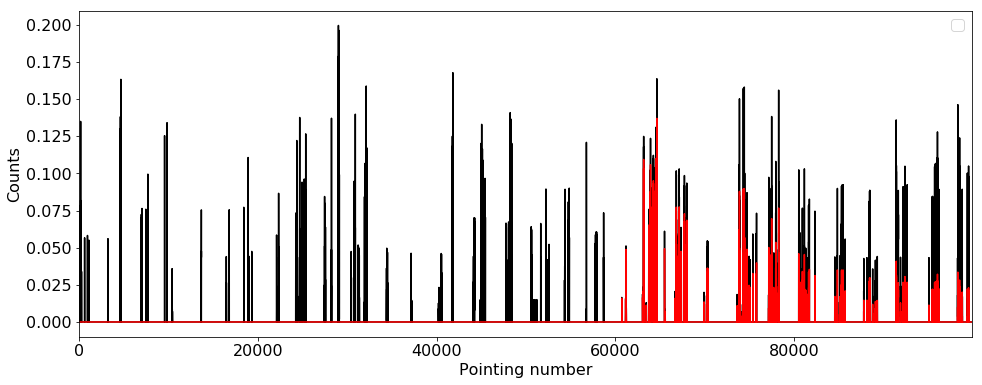

In [113]:
SPIl_plot(np.arange(Np),nova_model[0:Np,:]/flux_scale,
          y2=nova_model_decay)

<h3>Should look familiar, because we had this before.<br>
    Now we search, where the first non-zero entry is for this nova, so, following the plot, around pointing number 60000:</h3>

In [200]:
fidx = np.where(nova_model_decay[:,0] != 0)[0][0]
#fidx = Np-60 # I tested
print(fidx)

60724


<h3>Now, define the new numbers for the data set:</h3>

In [201]:
Np_decay = Np-fidx # number of pointings in reduced data set
Np_decay

39156

In [202]:
nova_model_decay[fidx:,:].shape

(39156, 19)

<h3>Because our background cuts start from 1 intrinsic to the data set, we also need to shift the indices accrodingly:</h3>

In [203]:
cuts_decay = np.array(all_cuts_unique[0])[np.array(all_cuts_unique[0])>=(fidx+1)]-(fidx)

In [205]:
[1]+list(cuts_decay[0:10]) # the 1 is important to not mess up the fit

[1, 39, 90, 116, 170, 246, 338, 429, 508, 591, 676]

<h3>What does that mean? We expect 38 pointings after the new first one (inclusive), to have a change in revolution:</h3>

In [210]:
print(poin['PTID_SPI'][fidx])
print(poin['PTID_SPI'][fidx+36:fidx+40])

12140037.000002
['12140073.000000' '12140074.000000' '12150011.000000' '12150012.000000']


<h3>Good: Entry 0 is in revolution 1214, pointing number 37.<br>
    Then, entry 36 (37th pointing) is still in 1214, entry 38 is in 1214 (38th pointing), and finally entry 39 is in 1215 (39th pointing), etc.</h3>

In [211]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1]+list(cuts_decay),Np_decay)

In [213]:
idx_arr[0:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

<h3>Looks reasonable, switching between 38 and 39, so the first Stan index should be 39.</h3>

<h3>Now building everything together as before, but now with the reduced data set:</h3>

In [218]:
# background cuts for about 40 parameters
bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(cuts_decay),Np_decay)

# good indices
idx = np.where(~((data[fidx:,:].ravel() == 0) & (bgl_model[fidx:,:].ravel() == 0) & (bgc_model[fidx:,:].ravel() == 0)))[0] + 1
Ngood = len(idx)

mu_flux_scl = np.array([0.])     # prior centroids for sky, we use 0 because we expect to see nothing
sigma_flux_scl = np.array([10.]) # width very broad (noninformative now) because we let the data talk
mu_Abg_lines = 1.                      # background as before
sigma_Abg_lines = 0.1                  # same
mu_Abg_conti = 1.                      # same
sigma_Abg_conti = 0.1                  # same


# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np_decay,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data[fidx:,:].ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[fidx:,:]),
              bg_model_conti = np.abs(bgc_model[fidx:,:]),
              conv_sky = nova_model_decay[fidx:,:].reshape(1,Np_decay,Nrsp), 
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

# init for specific cuts
init = {}
init['flux'] = np.array([1.0])
init['Abg_lines'] = np.repeat(1.0,Ncuts)
init['Abg_conti'] = np.repeat(1.0,Ncuts)

# optimize
start = time.time()
op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print(time.time()-start)

7.322076797485352


In [219]:
op_tmp['par']['flux']

array(1.00001714)

<h3>Seems to work. Now we sample the posteriors again, and see if we can fit this thing:</h3>

In [220]:
# sample full posterior
start = time.time()
fit_tmp = model.sampling(data=data2D,chains=1,iter=1000,n_jobs=-1,verbose=True,pars=['flux','Abg_lines','Abg_conti'])
print(time.time()-start)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


20426.499166965485


In [224]:
print(fit_tmp)

Inference for Stan model: anon_model_82974d80982aabf2b11051a2be36db84.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]          6.08     0.2   4.15   0.34   2.98   5.22   8.43  15.67    446    1.0
Abg_lines[1]     0.99  3.2e-3   0.09   0.81   0.93   0.99   1.05   1.15    697    1.0
Abg_lines[2]      1.0  3.1e-3   0.09   0.83   0.94    1.0   1.07   1.18    913    1.0
Abg_lines[3]      1.0  2.4e-3   0.08   0.84   0.95    1.0   1.06   1.16   1205    1.0
Abg_lines[4]      1.0  2.7e-3   0.09   0.82   0.94    1.0   1.06   1.16   1135    1.0
Abg_lines[5]      1.0  2.9e-3   0.09   0.82   0.95    1.0   1.07   1.18   1009    1.0
Abg_lines[6]      1.0  2.6e-3   0.08   0.85   0.94    1.0   1.05   1.16   1003    1.0
Abg_lines[7]      1.0  3.1e-3   0.09   0.84   0.94   1.01   1.06   1.18    837    1.0
Abg_lines[8]      1.0  2.9e-3   0.09   0

In [222]:
print('Upper limit (3sigma) on the 22Na (1275 keV) flux of '+data_frame['Name'][good_novae[ndx]]+': %.1fe-5' % (np.percentile(fit_tmp['flux'],99.85)))

Upper limit (3sigma) on the 22Na (1275 keV) flux of V959 Mon: 20.2e-5


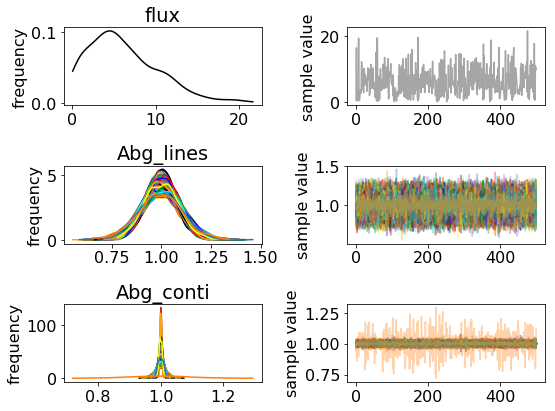

In [223]:
fit_tmp.plot(['flux','Abg_lines','Abg_conti'])
plt.tight_layout()

<h3>Congratulations, we have our first result for our paper:<br><br>
    Upper limit $3\sigma$ on the $^{22}\mathrm{Na}$ (1275 keV) flux from V959 Mon: $<2 \times 10^{-4}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$.<br><br>
    Now, fit the other 100 objects...</h3>

In [229]:
bg_cuts.shape

(39156,)

In [233]:
np.unique(bg_cuts)

(658,)

In [231]:
fit_tmp['Abg_conti'].shape

(500, 658)

Text(0, 0.5, 'Background Scaling')

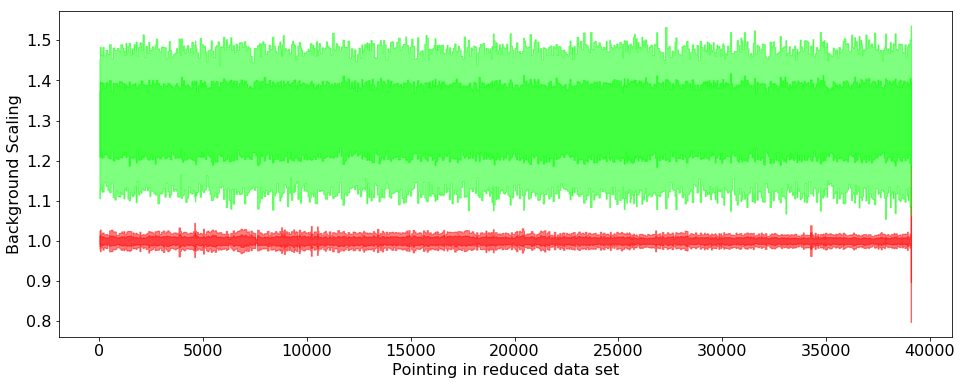

In [246]:
plt.figure(figsize=(16,6))
plt.fill_between(np.unique(bg_cuts),
                 np.percentile(fit_tmp['Abg_conti'],50+68.3/2,axis=0),
                 np.percentile(fit_tmp['Abg_conti'],50-68.3/2,axis=0),
                 step='mid',alpha=0.5,color='red')
plt.fill_between(np.unique(bg_cuts),
                 np.percentile(fit_tmp['Abg_conti'],50+95.4/2,axis=0),
                 np.percentile(fit_tmp['Abg_conti'],50-95.4/2,axis=0),
                 step='mid',alpha=0.5,color='red')

plt.fill_between(np.unique(bg_cuts),
                 np.percentile(fit_tmp['Abg_lines'],50+68.3/2,axis=0)+0.3,
                 np.percentile(fit_tmp['Abg_lines'],50-68.3/2,axis=0)+0.3,
                 step='mid',alpha=0.5,color='lime')
plt.fill_between(np.unique(bg_cuts),
                 np.percentile(fit_tmp['Abg_lines'],50+95.4/2,axis=0)+0.3,
                 np.percentile(fit_tmp['Abg_lines'],50-95.4/2,axis=0)+0.3,
                 step='mid',alpha=0.5,color='lime')

plt.xlabel('Pointing in reduced data set')
plt.ylabel('Background Scaling')

In [261]:
# background cuts for about 40 parameters
bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(1,Np,2500)),Np)

# good indices
idx = np.where(~((data.ravel() == 0) & (bgl_model.ravel() == 0) & (bgc_model.ravel() == 0)))[0] + 1
Ngood = len(idx)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              Ngood = Ngood,
              good_indices = idx,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = data.ravel().astype(int),
              bg_model_lines = np.abs(bgl_model[0:Np,:]),
              bg_model_conti = np.abs(bgc_model[0:Np,:]),
              conv_sky = nova_model[0:Np,:].reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg_lines = mu_Abg_lines,
              sigma_Abg_lines = sigma_Abg_lines,
              mu_Abg_conti = mu_Abg_conti,
              sigma_Abg_conti = sigma_Abg_conti)

In [262]:
data2D

{'N': 19,
 'Np': 99880,
 'Nsky': 1,
 'Ncuts': 40,
 'Ngood': 1595430,
 'good_indices': array([      1,       2,       3, ..., 1897717, 1897718, 1897720]),
 'bg_cuts': array([    1,     1,     1, ..., 97501, 97501, 97501]),
 'bg_idx_arr': array([ 1,  1,  1, ..., 40, 40, 40]),
 'y': array([115, 105, 100, ..., 312,   0, 266]),
 'bg_model_lines': array([[ 2.905748 ,  1.6242037,  2.7174604, ...,  2.499251 ,  2.4901779,
          2.5584338],
        [ 2.859628 ,  1.5982374,  2.6742375, ...,  2.4592736,  2.4506583,
          2.5172806],
        [ 2.910419 ,  1.6266984,  2.7221007, ...,  2.5033584,  2.4943738,
          2.562302 ],
        ...,
        [26.366184 ,  0.       ,  0.       , ..., 21.124302 ,  0.       ,
         19.677252 ],
        [26.339235 ,  0.       ,  0.       , ..., 21.104467 ,  0.       ,
         19.658154 ],
        [26.456446 ,  0.       ,  0.       , ..., 21.1973   ,  0.       ,
         19.743765 ]], dtype=float32),
 'bg_model_conti': array([[ 87.53494 ,  91.09569 , 

<h3>Go to sleep before you start this.</h3>

In [ ]:
start = time.time()
op3 = model.sampling(data=data2D,chains=1,iter=1000,n_jobs=-1,verbose=True,pars=['flux','Abg_lines','Abg_conti'])
print(time.time()-start)